# Tips dataset — Regression walkthrough

This notebook trains and evaluates four regressors (Linear Regression, Decision Tree, Support Vector Regressor, Random Forest) to predict **`tip`** using the Seaborn `tips` dataset. It includes data wrangling, limited EDA, a correlation heatmap, feature engineering, model training, evaluation (MAE, MSE, RMSE), actual vs predicted plots, and model saving.

**Libraries used:** `numpy`, `pandas`, `matplotlib`, `seaborn`, `scikit-learn`, `joblib`.

Run the cells sequentially in Jupyter Notebook / JupyterLab.

In [ ]:
pip install scikit-learn


In [1]:
# 1) Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import joblib

# plotting inline (Jupyter)
%matplotlib inline


In [2]:
# 2) Load dataset
df = sns.load_dataset('tips')
df.shape, df.head()

((244, 7),
    total_bill   tip     sex smoker  day    time  size
 0       16.99  1.01  Female     No  Sun  Dinner     2
 1       10.34  1.66    Male     No  Sun  Dinner     3
 2       21.01  3.50    Male     No  Sun  Dinner     3
 3       23.68  3.31    Male     No  Sun  Dinner     2
 4       24.59  3.61  Female     No  Sun  Dinner     4)

In [3]:
# 3) Quick data checks
print('Info:') 
df.info()
print('\nMissing values per column:')
print(df.isnull().sum())
print('\nDuplicate rows:', df.duplicated().sum())

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   total_bill  244 non-null    float64 
 1   tip         244 non-null    float64 
 2   sex         244 non-null    category
 3   smoker      244 non-null    category
 4   day         244 non-null    category
 5   time        244 non-null    category
 6   size        244 non-null    int64   
dtypes: category(4), float64(2), int64(1)
memory usage: 7.4 KB

Missing values per column:
total_bill    0
tip           0
sex           0
smoker        0
day           0
time          0
size          0
dtype: int64

Duplicate rows: 1


## 4) Limited EDA
- Target distribution
- Relationship between `total_bill` and `tip`
- Boxplot of `tip` by `day`
- Correlation matrix and heatmap (we will show numeric correlations)

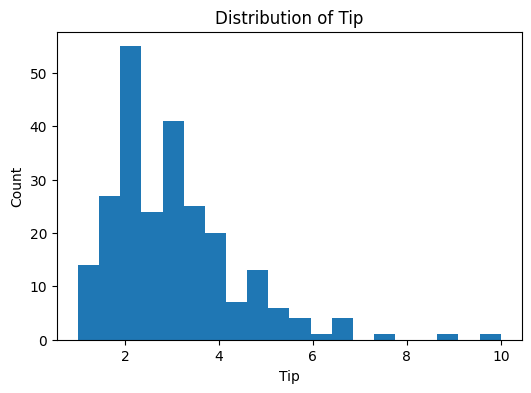

In [4]:
# Target distribution
plt.figure(figsize=(6,4))
plt.hist(df['tip'], bins=20)
plt.xlabel('Tip')
plt.ylabel('Count')
plt.title('Distribution of Tip');
plt.show()

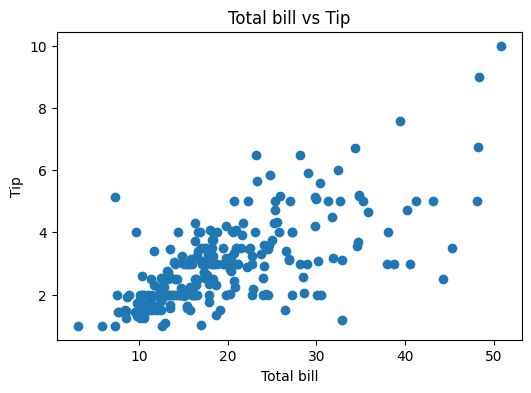

In [5]:
# total_bill vs tip
plt.figure(figsize=(6,4))
plt.scatter(df['total_bill'], df['tip'])
plt.xlabel('Total bill')
plt.ylabel('Tip')
plt.title('Total bill vs Tip');
plt.show()

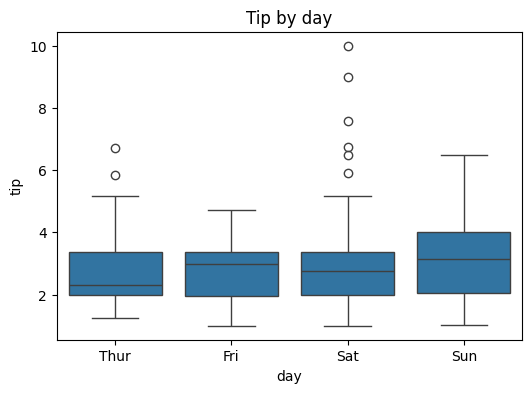

In [6]:
# Boxplot of tip by day
plt.figure(figsize=(6,4))
sns.boxplot(x='day', y='tip', data=df)
plt.title('Tip by day')
plt.show()

In [7]:
df.day.unique()

['Sun', 'Sat', 'Thur', 'Fri']
Categories (4, object): ['Thur', 'Fri', 'Sat', 'Sun']

In [8]:
# Correlation matrix (only numeric columns)
numeric = df.select_dtypes(include=[np.number])
corr = numeric.corr()
corr

,total_bill,tip,size
total_bill,1.000000,0.675734,0.598315
tip,0.675734,1.000000,0.489299
size,0.598315,0.489299,1.000000


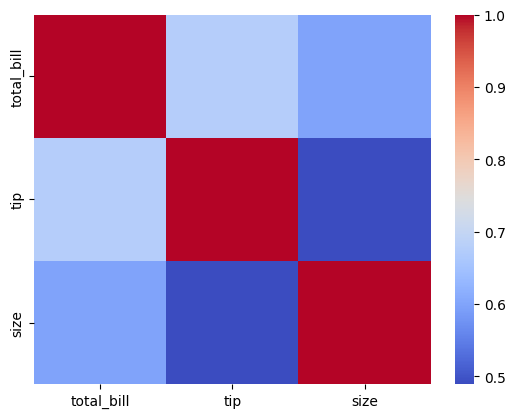

In [9]:
# Heatmap of correlation matrix
sns.heatmap(corr, cmap='coolwarm')
plt.show()

## 5) Feature engineering
- Create `bill_per_person` = total_bill / size
- Create binary `is_weekend` from `day`
- One-hot encode categorical features (`sex`, `smoker`, `day`, `time`)
- Scale numeric features for models that need it (we will use a ColumnTransformer inside a pipeline so the same preprocessing is used for all models).

In [10]:
# Feature engineering
df = df.copy()
df['bill_per_person'] = df['total_bill'] / df['size']
df['is_weekend'] = df['day'].isin(['Sat', 'Sun']).astype(int)

df.head()

,total_bill,tip,sex,smoker,day,time,size,bill_per_person,is_weekend
0,16.99,1.01,Female,No,Sun,Dinner,2,8.495000,1
1,10.34,1.66,Male,No,Sun,Dinner,3,3.446667,1
2,21.01,3.50,Male,No,Sun,Dinner,3,7.003333,1
3,23.68,3.31,Male,No,Sun,Dinner,2,11.840000,1
4,24.59,3.61,Female,No,Sun,Dinner,4,6.147500,1


In [ ]:
# Prepare X and y
target = 'tip'
X = df.drop(columns=[target])
y = df[target]

# Define feature groups
numeric_features = ['total_bill', 'size', 'bill_per_person', 'is_weekend']
categorical_features = ['sex', 'smoker', 'day', 'time'] 

X.shape, y.shape

((244, 8), (244,))

In [12]:
# Preprocessor: scale numeric and one-hot encode categorical (drop='first' to avoid multicollinearity)
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
])

## 6) Train / Test split
We'll use an 80/20 split with `random_state=42` for reproducibility.

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((195, 8), (49, 8))

## 7) Models to train
- Linear Regression
- Decision Tree Regressor
- Support Vector Regressor (SVR)
- Random Forest Regressor

We'll wrap each model into a pipeline that first applies the `preprocessor`.

# 7 a) Linear Regression

Linear Regression Results:
MAE: 0.6944164822872178
MSE: 0.7349415851132407
RMSE: 0.8572873410433871


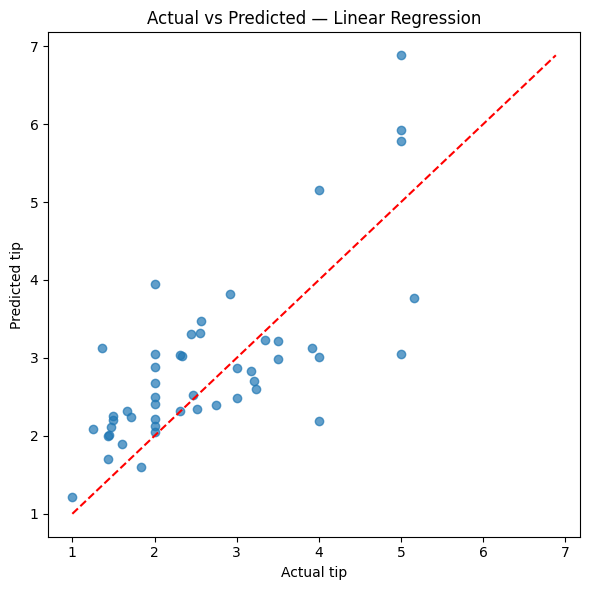

['model_linear_regression.joblib']

In [14]:
# Linear Regression
linreg_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Train
linreg_pipe.fit(X_train, y_train)

# Predict
y_pred_linreg = linreg_pipe.predict(X_test)

# Metrics
mse_linreg = mean_squared_error(y_test, y_pred_linreg)
mae_linreg = mean_absolute_error(y_test, y_pred_linreg)
rmse_linreg = np.sqrt(mean_squared_error(y_test, y_pred_linreg))

print("Linear Regression Results:")
print("MAE:", mae_linreg)
print("MSE:", mse_linreg)
print("RMSE:", rmse_linreg)

# Plot
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_linreg, alpha=0.7)
mn = min(y_test.min(), y_pred_linreg.min())
mx = max(y_test.max(), y_pred_linreg.max())
plt.plot([mn, mx], [mn, mx], linestyle='--', color='red')
plt.xlabel("Actual tip")
plt.ylabel("Predicted tip")
plt.title("Actual vs Predicted — Linear Regression")
plt.tight_layout()
plt.show()

# Save model
joblib.dump(linreg_pipe, "model_linear_regression.joblib")


# 7 b) Decision Tree Regressor

Decision Tree Results:
MAE: 0.7877551020408163
MSE: 1.0797183673469388
RMSE: 1.039094975133139


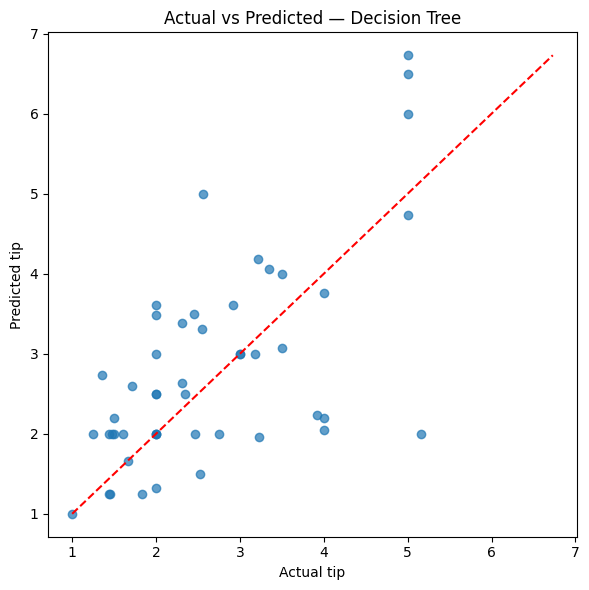

['model_decision_tree.joblib']

In [15]:
# Decision Tree
dt_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor(random_state=42))
])

# Train
dt_pipe.fit(X_train, y_train)

# Predict
y_pred_dt = dt_pipe.predict(X_test)

# Metrics
mse_dt = mean_squared_error(y_test, y_pred_dt)
mae_dt = mean_absolute_error(y_test, y_pred_dt)
rmse_dt = np.sqrt(mean_squared_error(y_test, y_pred_dt))

print("Decision Tree Results:")
print("MAE:", mae_dt)
print("MSE:", mse_dt)
print("RMSE:", rmse_dt)

# Plot
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_dt, alpha=0.7)
mn = min(y_test.min(), y_pred_dt.min())
mx = max(y_test.max(), y_pred_dt.max())
plt.plot([mn, mx], [mn, mx], linestyle='--', color='red')
plt.xlabel("Actual tip")
plt.ylabel("Predicted tip")
plt.title("Actual vs Predicted — Decision Tree")
plt.tight_layout()
plt.show()

# Save model
joblib.dump(dt_pipe, "model_decision_tree.joblib")


# 7 c) Support Vector Regressor

Support Vector Regressor Results:
MAE: 0.6591803052796418
MSE: 0.7256277633193183
RMSE: 0.8518378738464957


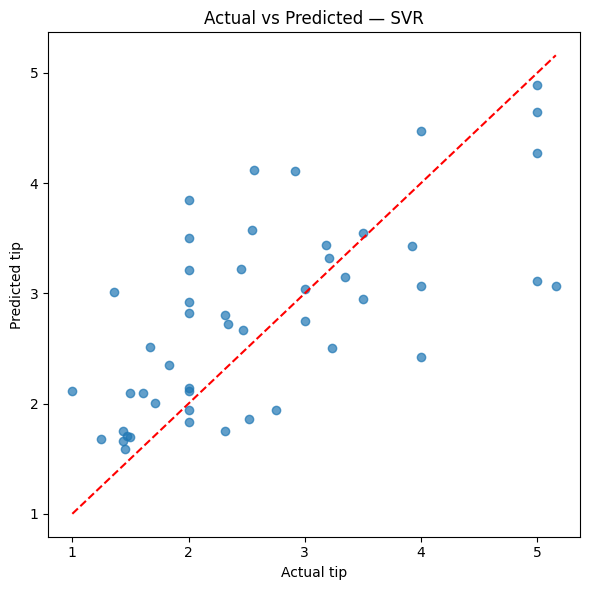

['model_svr.joblib']

In [16]:
# Support Vector Regressor
svr_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', SVR())
])

# Train
svr_pipe.fit(X_train, y_train)

# Predict
y_pred_svr = svr_pipe.predict(X_test)

# Metrics
mse_svr = mean_squared_error(y_test, y_pred_svr)
mae_svr = mean_absolute_error(y_test, y_pred_svr)
rmse_svr = np.sqrt(mean_squared_error(y_test, y_pred_svr))

print("Support Vector Regressor Results:")
print("MAE:", mae_svr)
print("MSE:", mse_svr)
print("RMSE:", rmse_svr)

# Plot
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_svr, alpha=0.7)
mn = min(y_test.min(), y_pred_svr.min())
mx = max(y_test.max(), y_pred_svr.max())
plt.plot([mn, mx], [mn, mx], linestyle='--', color='red')
plt.xlabel("Actual tip")
plt.ylabel("Predicted tip")
plt.title("Actual vs Predicted — SVR")
plt.tight_layout()
plt.show()

# Save model
joblib.dump(svr_pipe, "model_svr.joblib")


# 7 d) Random Forest Regressor

Random Forest Results:
MAE: 0.752544081632651
MSE: 0.8625524265550923
RMSE: 0.9287370061298797


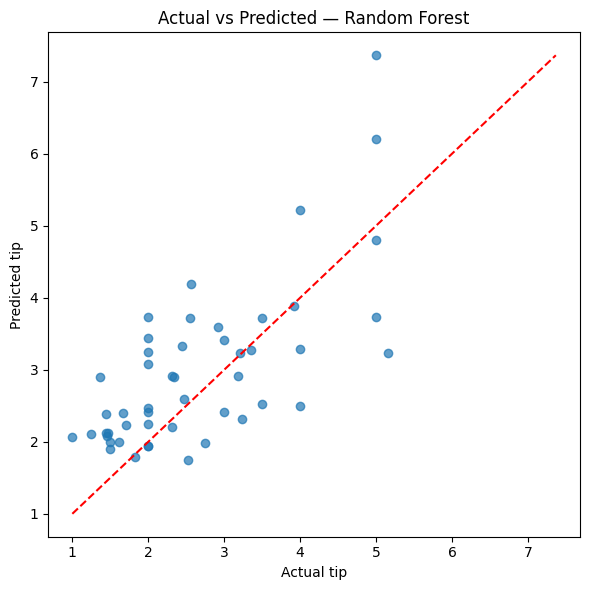

In [20]:
# Random Forest
rf_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=1000, random_state=1000))
])

# Train
rf_pipe.fit(X_train, y_train)

# Predict
y_pred_rf = rf_pipe.predict(X_test)

# Metrics
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print("Random Forest Results:")
print("MAE:", mae_rf)
print("MSE:", mse_rf)
print("RMSE:", rmse_rf)

# Plot
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_rf, alpha=0.7)
mn = min(y_test.min(), y_pred_rf.min())
mx = max(y_test.max(), y_pred_rf.max())
plt.plot([mn, mx], [mn, mx], linestyle='--', color='red')
plt.xlabel("Actual tip")
plt.ylabel("Predicted tip")
plt.title("Actual vs Predicted — Random Forest")
plt.tight_layout()
plt.show()

# Save model
#joblib.dump(rf_pipe, "model_random_forest.joblib")
